# Prototype Parameter, Signal, and Likelihood

These are all somewhat simplified versions of what I think we should have. I really want to incorporate the existing ``Prior`` structure into the parameter here. We also need to extend it to include EFACs per backend and include ECORR, etc but I like this metaclass type structure.

In [1]:
import numpy as np
import scipy.linalg as sl
from collections import OrderedDict
import matplotlib.pyplot as plt
import os

from enterprise.pulsar import Pulsar
import enterprise.constants as const
import enterprise.utils as util
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from corner import corner

% matplotlib inline

Do not have mpi4py package.
Do not have acor package


## Parameter class

In [2]:
# I didn't have time to study your parameter implementation, so this is my own

class Parameter(object):
    def __init__(self,name):
        self.name = name
    
    # this trick lets us pass an instantiated parameter to a signal;
    # the parameter will refuse to be renamed and will return itself
    def __call__(self,name):
        return self

# the following two are class *factories*: they return a customized class
# then the actual parameters (with names) are obtained by instantiating the class

def Uniform(pmin,pmax):
    # this naive class definition can be improved with type, etc.
    # but will be good enough for a demo
    class Uniform(Parameter):
        def log_pdf(self,p):
            return np.log(1.0 / (pmax - pmin)) if (pmin < p < pmax) else -np.inf
                
        def __repr__(self):
            return '"{}":Uniform({},{})'.format(self.name,pmin,pmax)
        
    return Uniform

def Normal(mu=0,sigma=1):
    class Normal(Parameter):
        norm = 1.0 / math.sqrt(2 * math.pi * sigma**2)
        
        def log_pdf(self,x):
            return np.log(self.norm * math.exp(-0.5*(x - mu)**2/sigma**2))
        
        def __repr__(self):
            return '"{0}": Normal({},{})'.format(self.name, mu, sigma)
        
    return Normal

class ConstantParameter(object):
    def __repr__(self):
        return '"{}":Constant={}'.format(self.name,self.value)        

def Constant(val):
    class Constant(Parameter, ConstantParameter):
        value = val
    
    return Constant

## Signal classes

In [3]:
class MetaSignal(type):
    def __add__(self,other):
        if isinstance(other,MetaSignal):
            return SignalCollection([self,other])
        elif isinstance(other,MetaCollection):
            return SignalCollection([self] + other._metasignals)
        else:
            raise TypeError
            
class MetaCollection(type):
    def __add__(self,other):
        if isinstance(other,MetaSignal):
            return SignalCollection(self._metasignals + [other])
        elif isinstance(other,MetaCollection):
            return SignalCollection(self._metasignals + other._metasignals)
        else:
            raise TypeError
            
# base signal class. Not much in it yet
class Signal(object):
    __metaclass__ = MetaSignal
    
    @property
    def params(self):
        # return only nonconstant parameters
        return [par for par in self._params.values() if not isinstance(par,ConstantParameter)]

    # note that we override the constant if parameter is given in dictionary?
    def get(self,parname,params={}):
        try:
            return params[self._params[parname].name]
        except KeyError:
            return self._params[parname].value
    
    def ndiag(self,params):
        return None
    
    def Fmat(self,params):
        return None
    
    def Phivec(self,params):
        return None
    
    def Phiinv(self,params):
        return None
    
def SignalCollection(metasignals):
    class SignalCollection(object):
        __metaclass__ = MetaCollection
        _metasignals = metasignals
        
        def __init__(self, psr):
            # instantiate all the signals with a pulsar
            self._signals = [metasignal(psr) for metasignal in self._metasignals]

        # we may consider defining __add__ also for instantiated signals. Why not... 

        @property
        def params(self):
            # this would allow duplicates
            # return set(param for signal in self._signals for param in signal.params)

            # no duplicates, but expensive, so a candidate for memoization
            ret = []
            for signal in self._signals:
                for param in signal.params:
                    if param not in ret:
                        ret.append(param)

            return ret

        # there may be a smarter way to write these...

        def ndiag(self,params):
            ndiags = [signal.ndiag(params) for signal in self._signals]
            return sum(ndiag for ndiag in ndiags if ndiag is not None)

        def Fmat(self,params):
            Fmats = [signal.Fmat(params) for signal in self._signals]
            return np.hstack(Fmat for Fmat in Fmats if Fmat is not None)

        def Phiinv(self,params):
            Phiinvs = [signal.Phiinv(params) for signal in self._signals]
            return np.hstack(Phiinv for Phiinv in Phiinvs if Phiinv is not None)    

        def Phivec(self,params):
            Phivecs = [signal.Phivec(params) for signal in self._signals]
            return np.hstack(Phivec for Phivec in Phivecs if Phivec is not None)
    
    return SignalCollection

def Function(f,**kwargs):
    class Function(object):
        def __init__(self,prefix):
            self._params = {kw: arg(prefix + '_' + kw) for kw,arg in kwargs.items()}
        
        def get(self,parname,params={}):
            try:
                return self._params[parname].value
            except AttributeError:
                return params[par.name]
        
        # params could also be a standard argument here,
        # but by defining it as ** we allow multiple positional arguments
        def __call__(self,*args,**params):
            pardict = {}
            for kw,par in self._params.items():
                if par.name in params:
                    pardict[kw] = params[par.name]
                elif hasattr(par,'value'):
                    pardict[kw] = par.value
                # allow fallback to function default arguments
                    
            return f(*args,**pardict)
        
        @property
        def params(self):
            return [par for par in self._params.values() if not isinstance(par,ConstantParameter)]
    
    return Function

In [4]:
def MeasurementNoise(efac = Uniform(0.5,1.5)):
    class MeasurementNoise(Signal):
        def __init__(self,psr):
            self._params = {'efac': efac(psr.name + '_efac')}
            self._ndiag = (psr.toaerrs)**2

        def ndiag(self,params):
            return self.get('efac',params)**2 * self._ndiag

    return MeasurementNoise

def EquadNoise(log10_equad = Uniform(-10,-5)):
    class EquadNoise(Signal):
        def __init__(self,psr):
            self._params = {'log10_equad': log10_equad(psr.name + '_log10_equad')}
            self._ndiag = np.ones_like(psr.toaerrs)

        def ndiag(self,params):
            return 10.0**(2*self.get('log10_equad',params)) * self._ndiag
    
    return EquadNoise

def FourierBasisGP(spectrum=None,components=20):
    class FourierBasisGP(Signal):
    
        def __init__(self,psr):
            self._spectrum = spectrum(psr.name)
            self._params = self._spectrum._params

            self._toas = psr.toas
            self._T = np.max(self._toas) - np.min(self._toas)
            
            self._F, self._f2, _ = util.createfourierdesignmatrix_red(
                self._toas, nmodes=components, freq=True)


        def Fmat(self,params=None):
            return self._F

        # maybe we only need diagonal Phi?
        def Phivec(self,params):
            return self._spectrum(self._f2,**params) / self._T

        def Phiinv(self,params):
            return self._T / self._spectrum(self._f2,**params)
    
    return FourierBasisGP

def TimingModel():
    class TimingModel(Signal):
        def __init__(self,psr):
            self._params = {}

            self._F = psr.Mmat

            norm = np.sqrt(np.sum(self._F**2,axis=0))
            self._F /= norm

            self._Phiinv = np.zeros(self._F.shape[1],'d')

        def Fmat(self,params=None):
            return self._F

        def Phivec(self,params=None):
            raise RuntimeError

        def Phiinv(self,params=None):
            return self._Phiinv
    
    return TimingModel

In [5]:
def powerlaw(f,log10_A=-16, gamma=5):
    return (10**log10_A)**2 / 12.0 / np.pi**2 * const.fyr**(gamma-3) * f**(-gamma)

## Likelihood class

In [6]:
import scipy.linalg as sl

class Likelihood(object):
    def __init__(self, psrs, signals):
        
        # for now we will assume that psrs and signals are lists
        # so that each pulsar has its own set of signals
        self._model = OrderedDict({})
        self._residuals = OrderedDict({})
        for psr, signal in zip(psrs, signals):
            self._model[psr.name] = signal(psr)
            self._residuals[psr.name] = psr.residuals
        
    @property
    def params(self):
        ret = []
        for model in self._model.values():
            for param in model.params:
                ret.append(param)
        return ret
    
    def map_params(self, xs):
        return {par.name: x for par, x in zip(self.params, xs)}

    # this can and should be much cleaner
    def get_lnlikelihood(self, xs):
        
        # map parameter vector
        params = self.map_params(xs)
        
        # start likelihood calculations
        loglike = 0
        for pname, model in self._model.items():
        
            # get auxiliaries
            Nvec = model.ndiag(params)
            T = model.Fmat(params)
            phiinv = model.Phiinv(params)
            residuals = self._residuals[pname]

            d = np.dot(T.T, residuals / Nvec)
            TNT = np.dot(T.T, T/Nvec[:,None])
            
            # log determinant of N
            logdet_N = np.sum(np.log(Nvec))
            
            # triple product in likelihood function
            rNr = np.sum(residuals**2/Nvec)

            # first component of likelihood function
            loglike += -0.5 * (logdet_N + rNr)
            
            # Red noise piece
            Sigma = TNT + np.diag(phiinv)
    
            cf = sl.cho_factor(Sigma)
            expval = sl.cho_solve(cf, d)
            logdet_sigma = np.sum(2 * np.log(np.diag(cf[0])))
            logdet_phi = np.sum(np.log(1/phiinv[phiinv!=0]))
            
            loglike += 0.5 * (np.dot(d, expval) - logdet_sigma - logdet_phi)
        
        return loglike
    
    def get_lnprior(self, xs):
        
        return np.sum(p.log_pdf(x) for p, x in zip(self.params, xs))

## Lets set up the pulsar model


In [7]:
# pulsar information
parfiles = ['./J1713+0747.par', './J1909-3744.par']
timfiles = ['./J1713+0747.tim', './J1909-3744.tim']

psrs = [Pulsar(p, t) for p, t in zip(parfiles, timfiles)]

In [8]:
# white noise
efac = Uniform(0.5, 5)
equad = Uniform(-10, -5)

ef = MeasurementNoise(efac=efac)
eq = EquadNoise(log10_equad=equad)

# red noise
pl = Function(powerlaw, log10_A=Uniform(-18,-12), gamma=Uniform(1,7))
rn = FourierBasisGP(spectrum=pl, components=30)

# timing model
tm = TimingModel()

# combined signal
s = ef + rn + tm

## Lets setup the likelihood and sample

In [9]:
lik = Likelihood(psrs, [s, s])

In [10]:
xs = np.array([1.0, -15.0, 4.33, 1.0, -14, 4.33])
print(lik.get_lnlikelihood(xs), lik.get_lnprior(xs))

(2005.9086380286026, -10.175192670464767)


In [11]:
# set up sampler
ndim = 6
p0 = np.array([1.0, -15.0, 2.0, 1.0, -13, 1.8])
cov = np.diag(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])**2)
sampler = ptmcmc(ndim, lik.get_lnlikelihood, lik.get_lnprior, cov)

In [12]:
N = 50000
sampler.sample(p0, N)

Finished 20.00 percent in 9.127687 s Acceptance rate = 0.348289Adding DE jump with weight 20
Finished 98.00 percent in 38.036552 s Acceptance rate = 0.393988
Run Complete


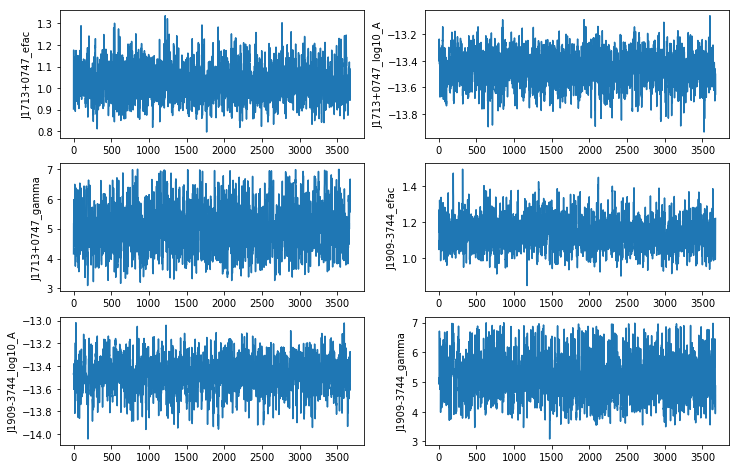

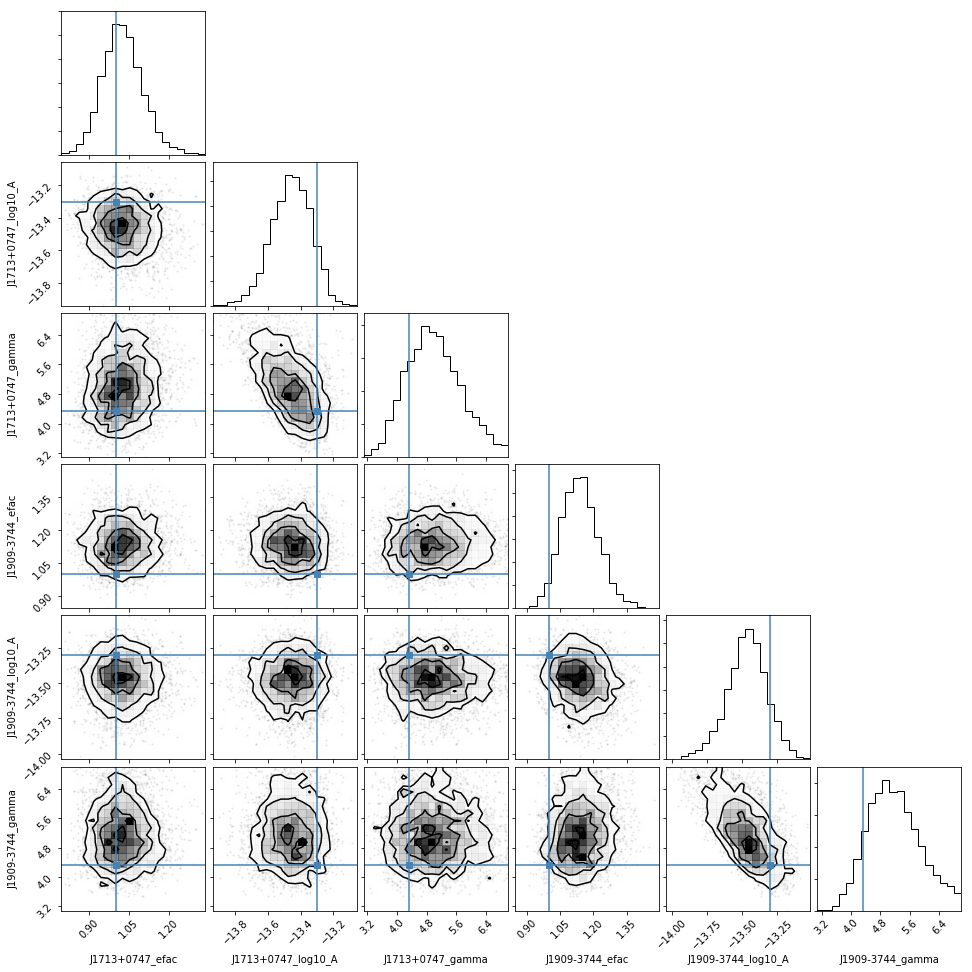

In [13]:
chain = np.loadtxt('chains/chain_1.txt')
burn = int(0.25*chain.shape[0])
pars = [p.name for p in lik.params]

plt.figure(figsize=(12, 8))
for ii in range(6):
    plt.subplot(3,2,ii+1)
    plt.plot(chain[burn:,ii])
    plt.ylabel(pars[ii])
    
truths = [1.0, np.log10(5e-14), 4.33, 1.0, np.log10(5e-14), 4.33]

ax = corner(chain[burn:,:-4], truths=truths, labels=pars)